## Time Series Prediction with LSTM Recurrent Neural Networks in Python with Keras
### Adapted from:
- https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/

In [120]:
%reset -f

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math as mt

# Keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.utils import plot_model

# SkLearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

%matplotlib inline

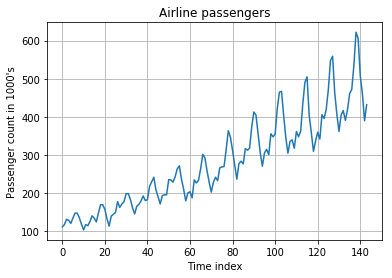

In [121]:
dataset = pd.read_csv('international-airline-passengers.csv', usecols=[1], engine='python', skipfooter=3)

plt.plot(dataset)
plt.grid()
plt.title('Airline passengers')
plt.xlabel('Time index')
plt.ylabel('Passenger count in 1000\'s')
plt.show()

## Long Short-Term Memory Network
- The Long Short-Term Memory network, or LSTM network, is a recurrent neural network that is trained using Backpropagation Through Time and overcomes the vanishing gradient problem.
- As such, it can be used to create large recurrent networks that in turn can be used to address difficult sequence problems in machine learning and achieve state-of-the-art results.
- Instead of neurons, LSTM networks have memory blocks that are connected through layers.
- A block has components that make it smarter than a classical neuron and a memory for recent sequences. A block contains gates that manage the block’s state and output. A block operates upon an input sequence and each gate within a block uses the sigmoid activation units to control whether they are triggered or not, making the change of state and addition of information flowing through the block conditional.
- There are three types of gates within a unit:
    - **Forget Gate**: conditionally decides what information to throw away from the block.
    - **Input Gate**: conditionally decides which values from the input to update the memory state.
    - **Output Gate**: conditionally decides what to output based on input and the memory of the block.
- Each unit is like a mini-state machine where the gates of the units have weights that are learned during the training procedure.
- You can see how you may achieve sophisticated learning and memory from a layer of LSTMs, and it is not hard to imagine how higher-order abstractions may be layered with multiple such layers.

## LSTM Network for Regression
- We can phrase the problem as a regression problem.
- That is, given the number of passengers (in units of thousands) this month, what is the number of passengers next month?
- We can write a simple function to convert our single column of data into a two-column dataset: the first column containing this month’s (t) passenger count and the second column containing next month’s (t+1) passenger count, to be predicted.
- **LSTMs are sensitive to the scale of the input data**, specifically when the sigmoid (default) or tanh activation functions are used. It can be a good practice to rescale the data to the range of 0-to-1, also called normalizing. We can easily normalize the dataset using the MinMaxScaler preprocessing class from the scikit-learn library.

In [122]:
# Fix random seed for reproducibility
np.random.seed(7)

# Load the data
dataframe = pd.read_csv('international-airline-passengers.csv', usecols=[1], engine='python', skipfooter=3)
dataset = dataframe.values
dataset = dataset.astype('float32')

print "Pre-Normalization:\n", dataset[0:5]

# Normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

print "\nPost-Normalization:\n", dataset[0:5]

Pre-Normalization:
[[ 112.]
 [ 118.]
 [ 132.]
 [ 129.]
 [ 121.]]

Post-Normalization:
[[ 0.01544401]
 [ 0.02702703]
 [ 0.05405405]
 [ 0.04826255]
 [ 0.03281853]]


- After we model our data and estimate the skill of our model on the training dataset, we need to get an idea of the skill of the model on new unseen data. For a normal classification or regression problem, we would do this using cross validation.
- With time series data, **the sequence of values is important**. A simple method that we can use is to split the ordered dataset into train and test datasets. The code below calculates the index of the split point and separates the data into the training datasets with 67% of the observations that we can use to train our model, leaving the remaining 33% for testing the model.
    - Ref.: TimeSeriesExperimentation/04_BacktestMachineLearningModelsForTimeSeriesForecasting

In [123]:
# Split into training and testing sets
trainSizeRatio = 0.67

trainSize = int(len(dataset) * trainSizeRatio)
testSize = len(dataset) - trainSize

train, test = dataset[0:trainSize, :], dataset[trainSize:len(dataset), :]

print "Dataset size:  ", len(dataset)
print "Training size: ", len(train)
print "Testing size:  ", len(test)

Dataset size:   144
Training size:  96
Testing size:   48


- Now we can define a function to create a new dataset, as described above.
- The function takes two arguments: the dataset, which is a NumPy array that we want to convert into a dataset, and the look_back, which is the number of previous time steps to use as input variables to predict the next time period — in this case defaulted to 1.
- This default will create a dataset where X is the number of passengers at a given time (t) and Y is the number of passengers at the next time (t + 1).
- It can be configured, and we will by constructing a differently shaped dataset in the next section.
- Ref.: TimeSeriesExperimentation/01_TimeSeriesToSupervisedLearningProblem

In [124]:
# Convert an array of values into a dataset matrix
# i.e. convert a Time Series problem into a Supervised problem
def createDataset(dataset, lookBack=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - lookBack - 1):
        a = dataset[i:(i + lookBack), 0]
        dataX.append(a)
        dataY.append(dataset[i + lookBack, 0])

    return np.array(dataX), np.array(dataY)

In [125]:
# Reshape into X=t and Y=t+1 --> Supervised problem
lookBack = 1
trainX, trainY = createDataset(train, lookBack)
testX, testY = createDataset(test, lookBack)

print "Shifted training Data:"
print "X: ", trainX[0:5, 0]
print "Y: ", trainY[0:5]

print "\nShifted testing Data:"
print "X: ", testX[0:5, 0]
print "Y: ", testY[0:5]

Shifted training Data:
X:  [ 0.01544401  0.02702703  0.05405405  0.04826255  0.03281853]
Y:  [ 0.02702703  0.05405405  0.04826255  0.03281853  0.05984557]

Shifted testing Data:
X:  [ 0.40733591  0.3803089   0.48648646  0.47104248  0.48455599]
Y:  [ 0.3803089   0.48648646  0.47104248  0.48455599  0.61389959]


- The LSTM network expects the input data (X) to be provided with a specific array structure in the form of:
    - [samples, time steps, features].
- Currently, our data is in the form: [samples, features] and we are framing the problem as one time step for each sample. We can transform the prepared train and test input data into the expected structure using numpy.reshape() as follows:

In [126]:
# Reshape input to be [samples, time steps, features]

print "Before: trainX.shape = ", trainX.shape
print "Before: testX.shape  = ", testX.shape

trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

print "\nAfter: trainX.shape  = ", trainX.shape
print "After: testX.shape   = ", testX.shape

Before: trainX.shape =  (94, 1)
Before: testX.shape  =  (46, 1)

After: trainX.shape  =  (94, 1, 1)
After: testX.shape   =  (46, 1, 1)


- We are now ready to design and fit our LSTM network for this problem.
- The network has a visible layer with 1 input, a hidden layer with 4 LSTM blocks or neurons, and an output layer that makes a single value prediction. The default sigmoid activation function is used for the LSTM blocks. The network is trained for 100 epochs and a batch size of 1 is used.

In [127]:
# Create and fit the LSTM network
model = Sequential()

model.add(LSTM(4, input_shape=(1, lookBack)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

modelHistory = model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

plot_model(model, to_file='model.png', show_shapes=True)

Epoch 1/100
 - 1s - loss: 0.0413
Epoch 2/100
 - 0s - loss: 0.0202
Epoch 3/100
 - 0s - loss: 0.0146
Epoch 4/100
 - 0s - loss: 0.0131
Epoch 5/100
 - 0s - loss: 0.0121
Epoch 6/100
 - 0s - loss: 0.0111
Epoch 7/100
 - 0s - loss: 0.0102
Epoch 8/100
 - 0s - loss: 0.0093
Epoch 9/100
 - 0s - loss: 0.0081
Epoch 10/100
 - 0s - loss: 0.0071
Epoch 11/100
 - 0s - loss: 0.0062
Epoch 12/100
 - 0s - loss: 0.0053
Epoch 13/100
 - 0s - loss: 0.0045
Epoch 14/100
 - 0s - loss: 0.0038
Epoch 15/100
 - 0s - loss: 0.0033
Epoch 16/100
 - 0s - loss: 0.0029
Epoch 17/100
 - 0s - loss: 0.0026
Epoch 18/100
 - 0s - loss: 0.0024
Epoch 19/100
 - 0s - loss: 0.0022
Epoch 20/100
 - 0s - loss: 0.0022
Epoch 21/100
 - 0s - loss: 0.0021
Epoch 22/100
 - 0s - loss: 0.0021
Epoch 23/100
 - 0s - loss: 0.0021
Epoch 24/100
 - 0s - loss: 0.0021
Epoch 25/100
 - 0s - loss: 0.0020
Epoch 26/100
 - 0s - loss: 0.0021
Epoch 27/100
 - 0s - loss: 0.0020
Epoch 28/100
 - 0s - loss: 0.0020
Epoch 29/100
 - 0s - loss: 0.0020
Epoch 30/100
 - 0s - lo

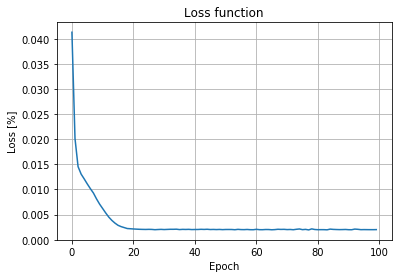

In [128]:
# Visualize LSTM network architecture
plot_model(model, to_file='model.png', show_shapes=True)

# Plot loss variation with trianing epochs
plt.plot(modelHistory.history['loss'])
plt.grid()
plt.title('Loss function')
plt.xlabel('Epoch')
plt.ylabel('Loss [%]')
plt.show()

- Once the model is fit, we can estimate the performance of the model on the training and testing datasets. This will give us a point of comparison for new models.
- Note that we invert the predictions before calculating error scores to ensure that performance is reported in the same units as the original data (thousands of passengers per month).

In [129]:
# Make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# Invert predictions
trainPredictInverted = scaler.inverse_transform(trainPredict)
trainYInverted = scaler.inverse_transform([trainY])

testPredictInverted = scaler.inverse_transform(testPredict)
testYInverted = scaler.inverse_transform([testY])

# Calculate root mean squared error
trainScore = mt.sqrt(mean_squared_error(trainYInverted[0], trainPredictInverted[:,0]))
print 'Train Score: %.2f RMSE' % (trainScore)

testScore = mt.sqrt(mean_squared_error(testYInverted[0], testPredictInverted[:,0]))
print 'Test Score:  %.2f RMSE' % (testScore)

Train Score: 22.93 RMSE
Test Score:  47.53 RMSE


- Finally, we can generate predictions using the model for both the train and test dataset to get a visual indication of the skill of the model.
- Because of how the dataset was prepared, we must shift the predictions so that they align on the x-axis with the original dataset. Once prepared, the data is plotted, showing the original dataset in blue, the predictions for the training dataset in green, and the predictions on the unseen test dataset in red.

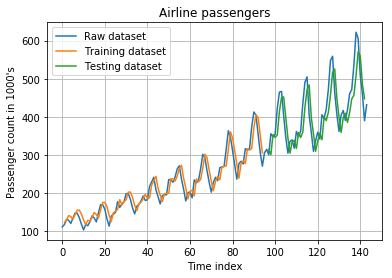

In [130]:
# Shift training predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[lookBack:len(trainPredict) + lookBack, :] = trainPredictInverted

# Shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict) + (lookBack * 2) + 1:len(dataset) - 1, :] = testPredictInverted

# Plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.grid()
plt.title('Airline passengers')
plt.xlabel('Time index')
plt.ylabel('Passenger count in 1000\'s')
plt.legend(['Raw dataset', 'Training dataset', 'Testing dataset'])
plt.show()